In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scipy
import time
import sklearn
from importlib import reload
from scipy.spatial.distance import cdist

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

# Model Loss

In [2]:
dpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/training_metrics/"

file_list = glob.glob(f"{dpath}*")

df = []

for fpath in file_list:
    basename = os.path.basename(fpath)
    n_genes = int(basename.split("_")[0].replace("hvg", ""))
    loss_type = basename.split("_")[1].replace(".csv", "")

    tmp = pd.read_csv(fpath)
    tmp['n_genes'] = n_genes
    tmp['loss_type'] = loss_type
    df.append(tmp)

df = pd.concat(df)
df['model'] = df['n_genes'].astype(str)
df.head()

,epoch,validation_loss,elbo_validation,reconstruction_loss_validation,kl_local_validation,kl_global_validation,train_loss_epoch,elbo_train,reconstruction_loss_train,kl_local_train,...,loss_type,validation_classification_loss,validation_accuracy,validation_f1_score,validation_calibration_error,train_classification_loss,train_accuracy,train_f1_score,train_calibration_error,model
0,0,12132.745117,12135.984375,12132.745117,3.238889,0.0,12260.972656,12265.017578,12260.972656,4.044833,...,scvi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000
1,1,11962.829102,11966.491211,11962.820312,3.670443,0.0,12071.777344,12076.503906,12071.766602,4.736909,...,scvi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000
2,2,11794.251953,11798.479492,11794.230469,4.249361,0.0,11904.144531,11909.307617,11904.119141,5.188896,...,scvi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000
3,3,11629.648438,11634.502930,11629.611328,4.891717,0.0,11739.667969,11745.234375,11739.626953,5.607548,...,scvi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000
4,4,11470.526367,11476.030273,11470.470703,5.559382,0.0,11578.719727,11584.720703,11578.661133,6.059305,...,scvi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000


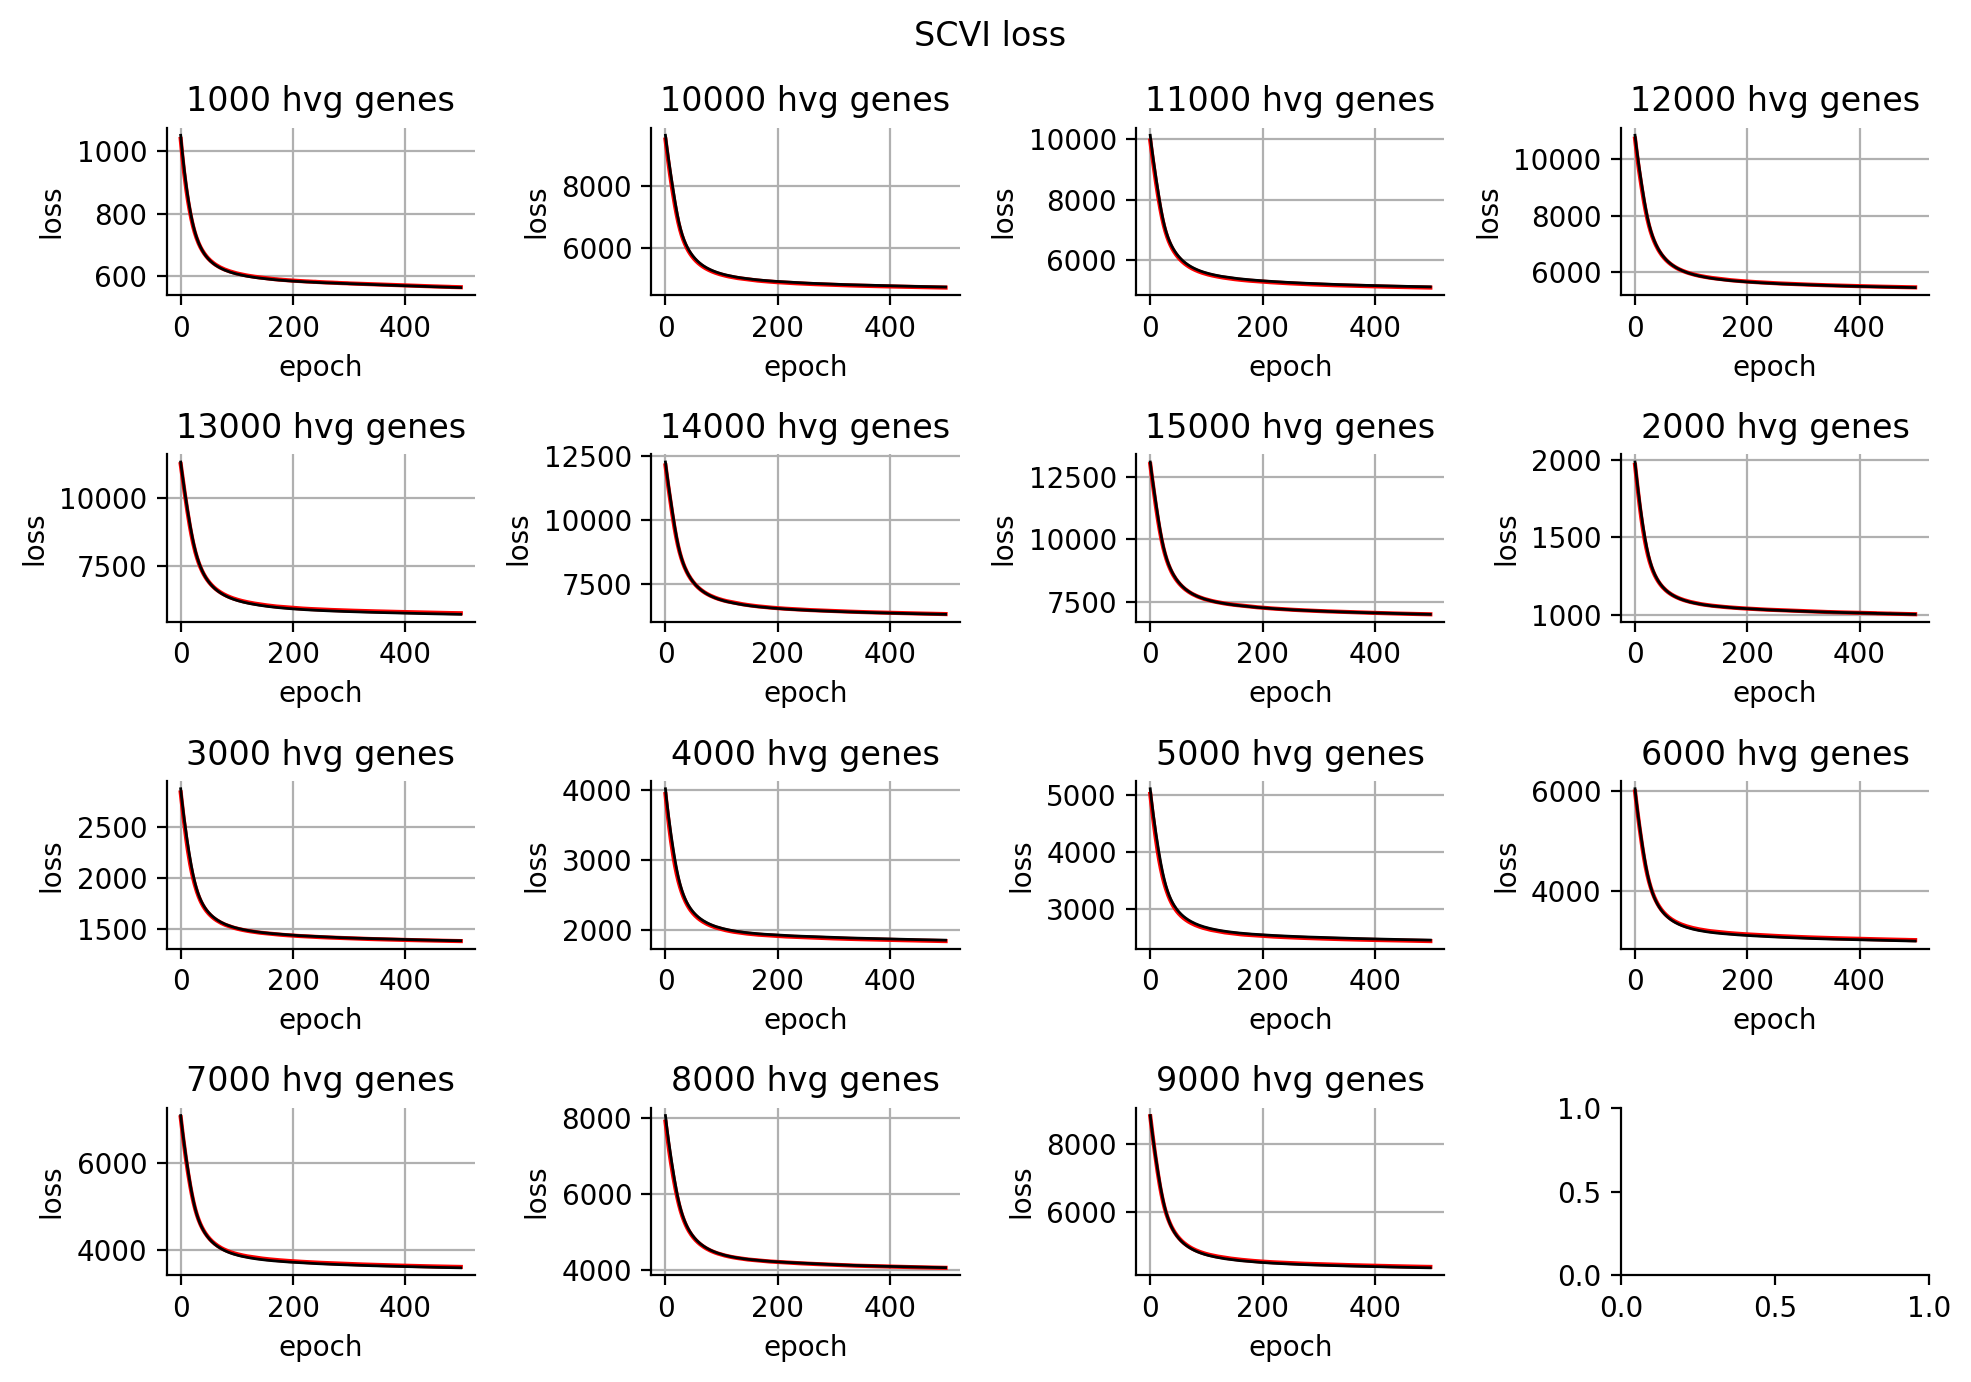

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 7

pdf = df.copy()
pdf = pdf[pdf['loss_type'] == 'scvi']

fig, axs = plt.subplots(4, 4)
axs = axs.ravel()

for i, (model, group) in enumerate(pdf.groupby('model')):

    sns.lineplot(
        data=group,
        x='epoch',
        y='validation_loss',
        ax=axs[i],
        c='r',
    )

    sns.lineplot(
        data=group,
        x='epoch',
        y='train_loss_epoch',
        ax=axs[i],
        lw=1,
        c='k',
    )

    axs[i].set_ylabel('loss')
    axs[i].set_xlabel('epoch')
    axs[i].set_title(f"{model} hvg genes")
    axs[i].grid(True)

plt.suptitle("SCVI loss")
sns.despine()
plt.tight_layout()

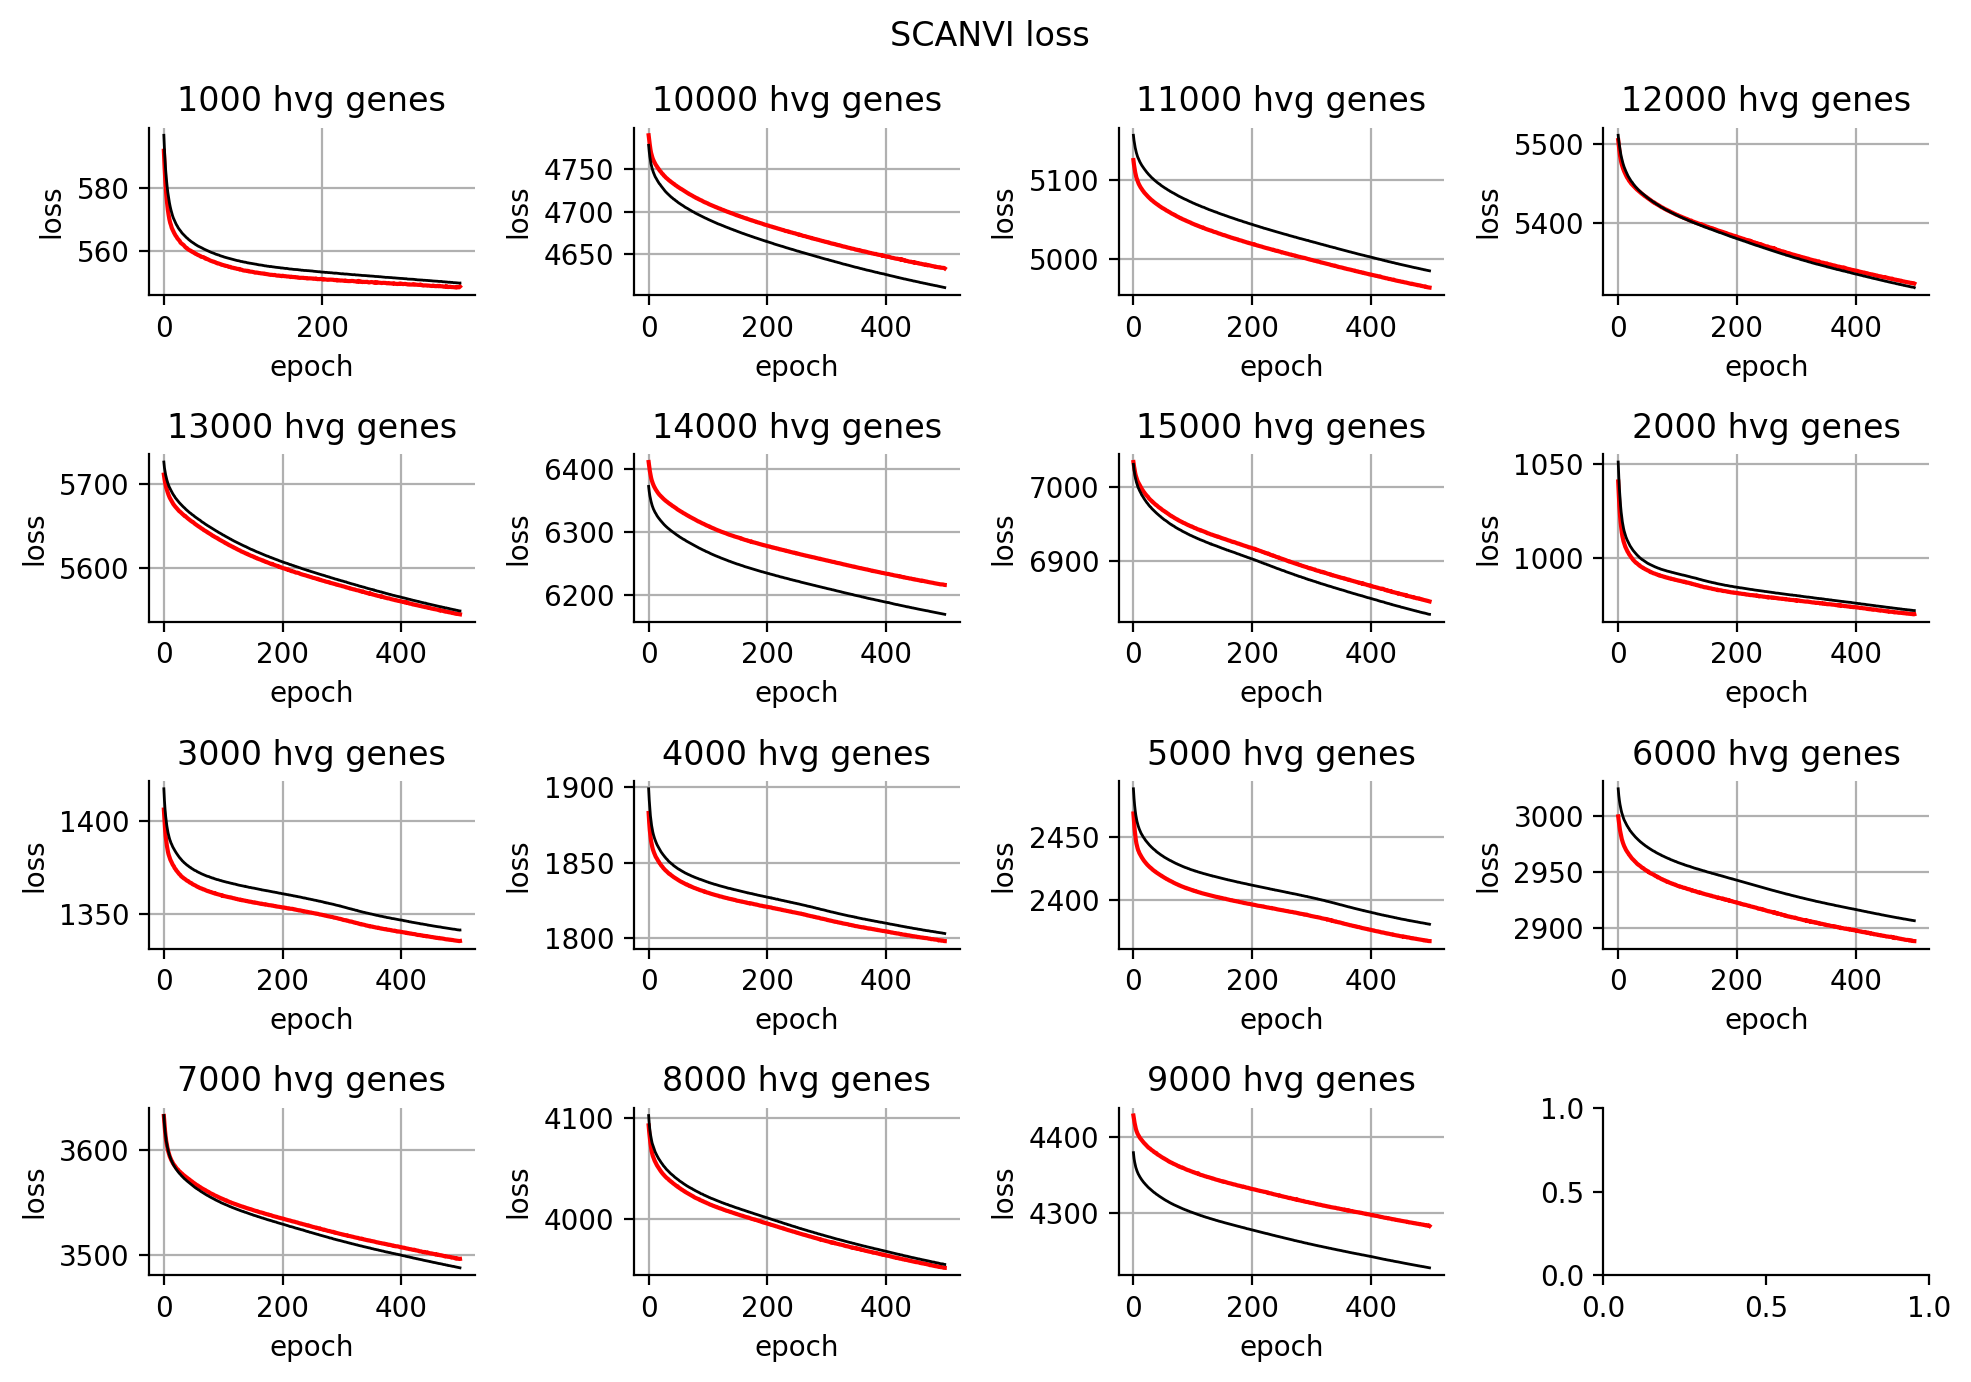

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 7

pdf = df.copy()
pdf = pdf[pdf['loss_type'] == 'scanvi']

fig, axs = plt.subplots(4, 4)
axs = axs.ravel()

for i, (model, group) in enumerate(pdf.groupby('model')):

    sns.lineplot(
        data=group,
        x='epoch',
        y='validation_loss',
        ax=axs[i],
        c='r',
    )

    sns.lineplot(
        data=group,
        x='epoch',
        y='train_loss_epoch',
        ax=axs[i],
        lw=1,
        c='k',
    )

    axs[i].set_ylabel('loss')
    axs[i].set_xlabel('epoch')
    axs[i].set_title(f"{model} hvg genes")
    axs[i].grid(True)

plt.suptitle("SCANVI loss")
sns.despine()
plt.tight_layout()

In [5]:
# break

# Benchmarking

In [6]:
dpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/"

file_list = glob.glob(f"{dpath}*")
file_list[:5]

['/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/hvg12000_benchmark.csv',
 '/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/hvg9000_benchmark.csv',
 '/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/hvg10000_benchmark.csv',
 '/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/hvg15000_benchmark.csv',
 '/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/benchmarks/hvg4000_benchmark.csv']

In [7]:
df = []

for fpath in file_list:
    basename = os.path.basename(fpath)
    n_genes = int(basename.split("_")[0].replace("hvg", ""))

    tmp = pd.read_csv(fpath)
    tmp = tmp[tmp['Embedding'] != 'Metric Type']
    tmp['n_genes'] = n_genes
    df.append(tmp)

df = pd.concat(df)

for x in df.columns:
    if x == 'Embedding':
        continue

    df[x] = df[x].astype(float)
    
df.head()

,Embedding,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total,n_genes
0,X_pca,0.959657,0.001327,-0.000968,0.247748,1.0,0.501424,3.973643e-08,0.014891,0.898060,0.000000,0.282875,0.441553,0.378082,12000.0
1,X_scanorama,0.977082,0.001427,-0.001041,0.240629,1.0,0.483755,6.622738e-08,0.059251,0.830052,0.000000,0.274612,0.443619,0.376016,12000.0
2,X_harmony,0.973773,0.001427,-0.001041,0.201620,1.0,0.453045,2.725654e-04,0.254427,0.896437,0.253448,0.371526,0.435156,0.409704,12000.0
3,X_scvi,0.940480,0.725366,0.684548,0.660880,1.0,0.666368,2.649095e-08,0.039402,0.896944,0.000000,0.320543,0.802255,0.609570,12000.0
4,X_scanvi,0.787912,0.740687,0.685098,0.653325,1.0,0.788539,1.858340e-04,0.259116,0.912045,0.000000,0.391977,0.773404,0.620834,12000.0


,Embedding,Isolated labels,KMeans NMI,KMeans ARI,Silhouette label,cLISI,Silhouette batch,iLISI,KBET,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total,n_genes
0,X_pca,0.959657,0.001327,-0.000968,0.247748,1.0,0.501424,3.973643e-08,0.014891,0.898060,0.000000,0.282875,0.441553,0.378082,12000.0
1,X_scanorama,0.977082,0.001427,-0.001041,0.240629,1.0,0.483755,6.622738e-08,0.059251,0.830052,0.000000,0.274612,0.443619,0.376016,12000.0
2,X_harmony,0.973773,0.001427,-0.001041,0.201620,1.0,0.453045,2.725654e-04,0.254427,0.896437,0.253448,0.371526,0.435156,0.409704,12000.0
3,X_scvi,0.940480,0.725366,0.684548,0.660880,1.0,0.666368,2.649095e-08,0.039402,0.896944,0.000000,0.320543,0.802255,0.609570,12000.0
4,X_scanvi,0.787912,0.740687,0.685098,0.653325,1.0,0.788539,1.858340e-04,0.259116,0.912045,0.000000,0.391977,0.773404,0.620834,12000.0


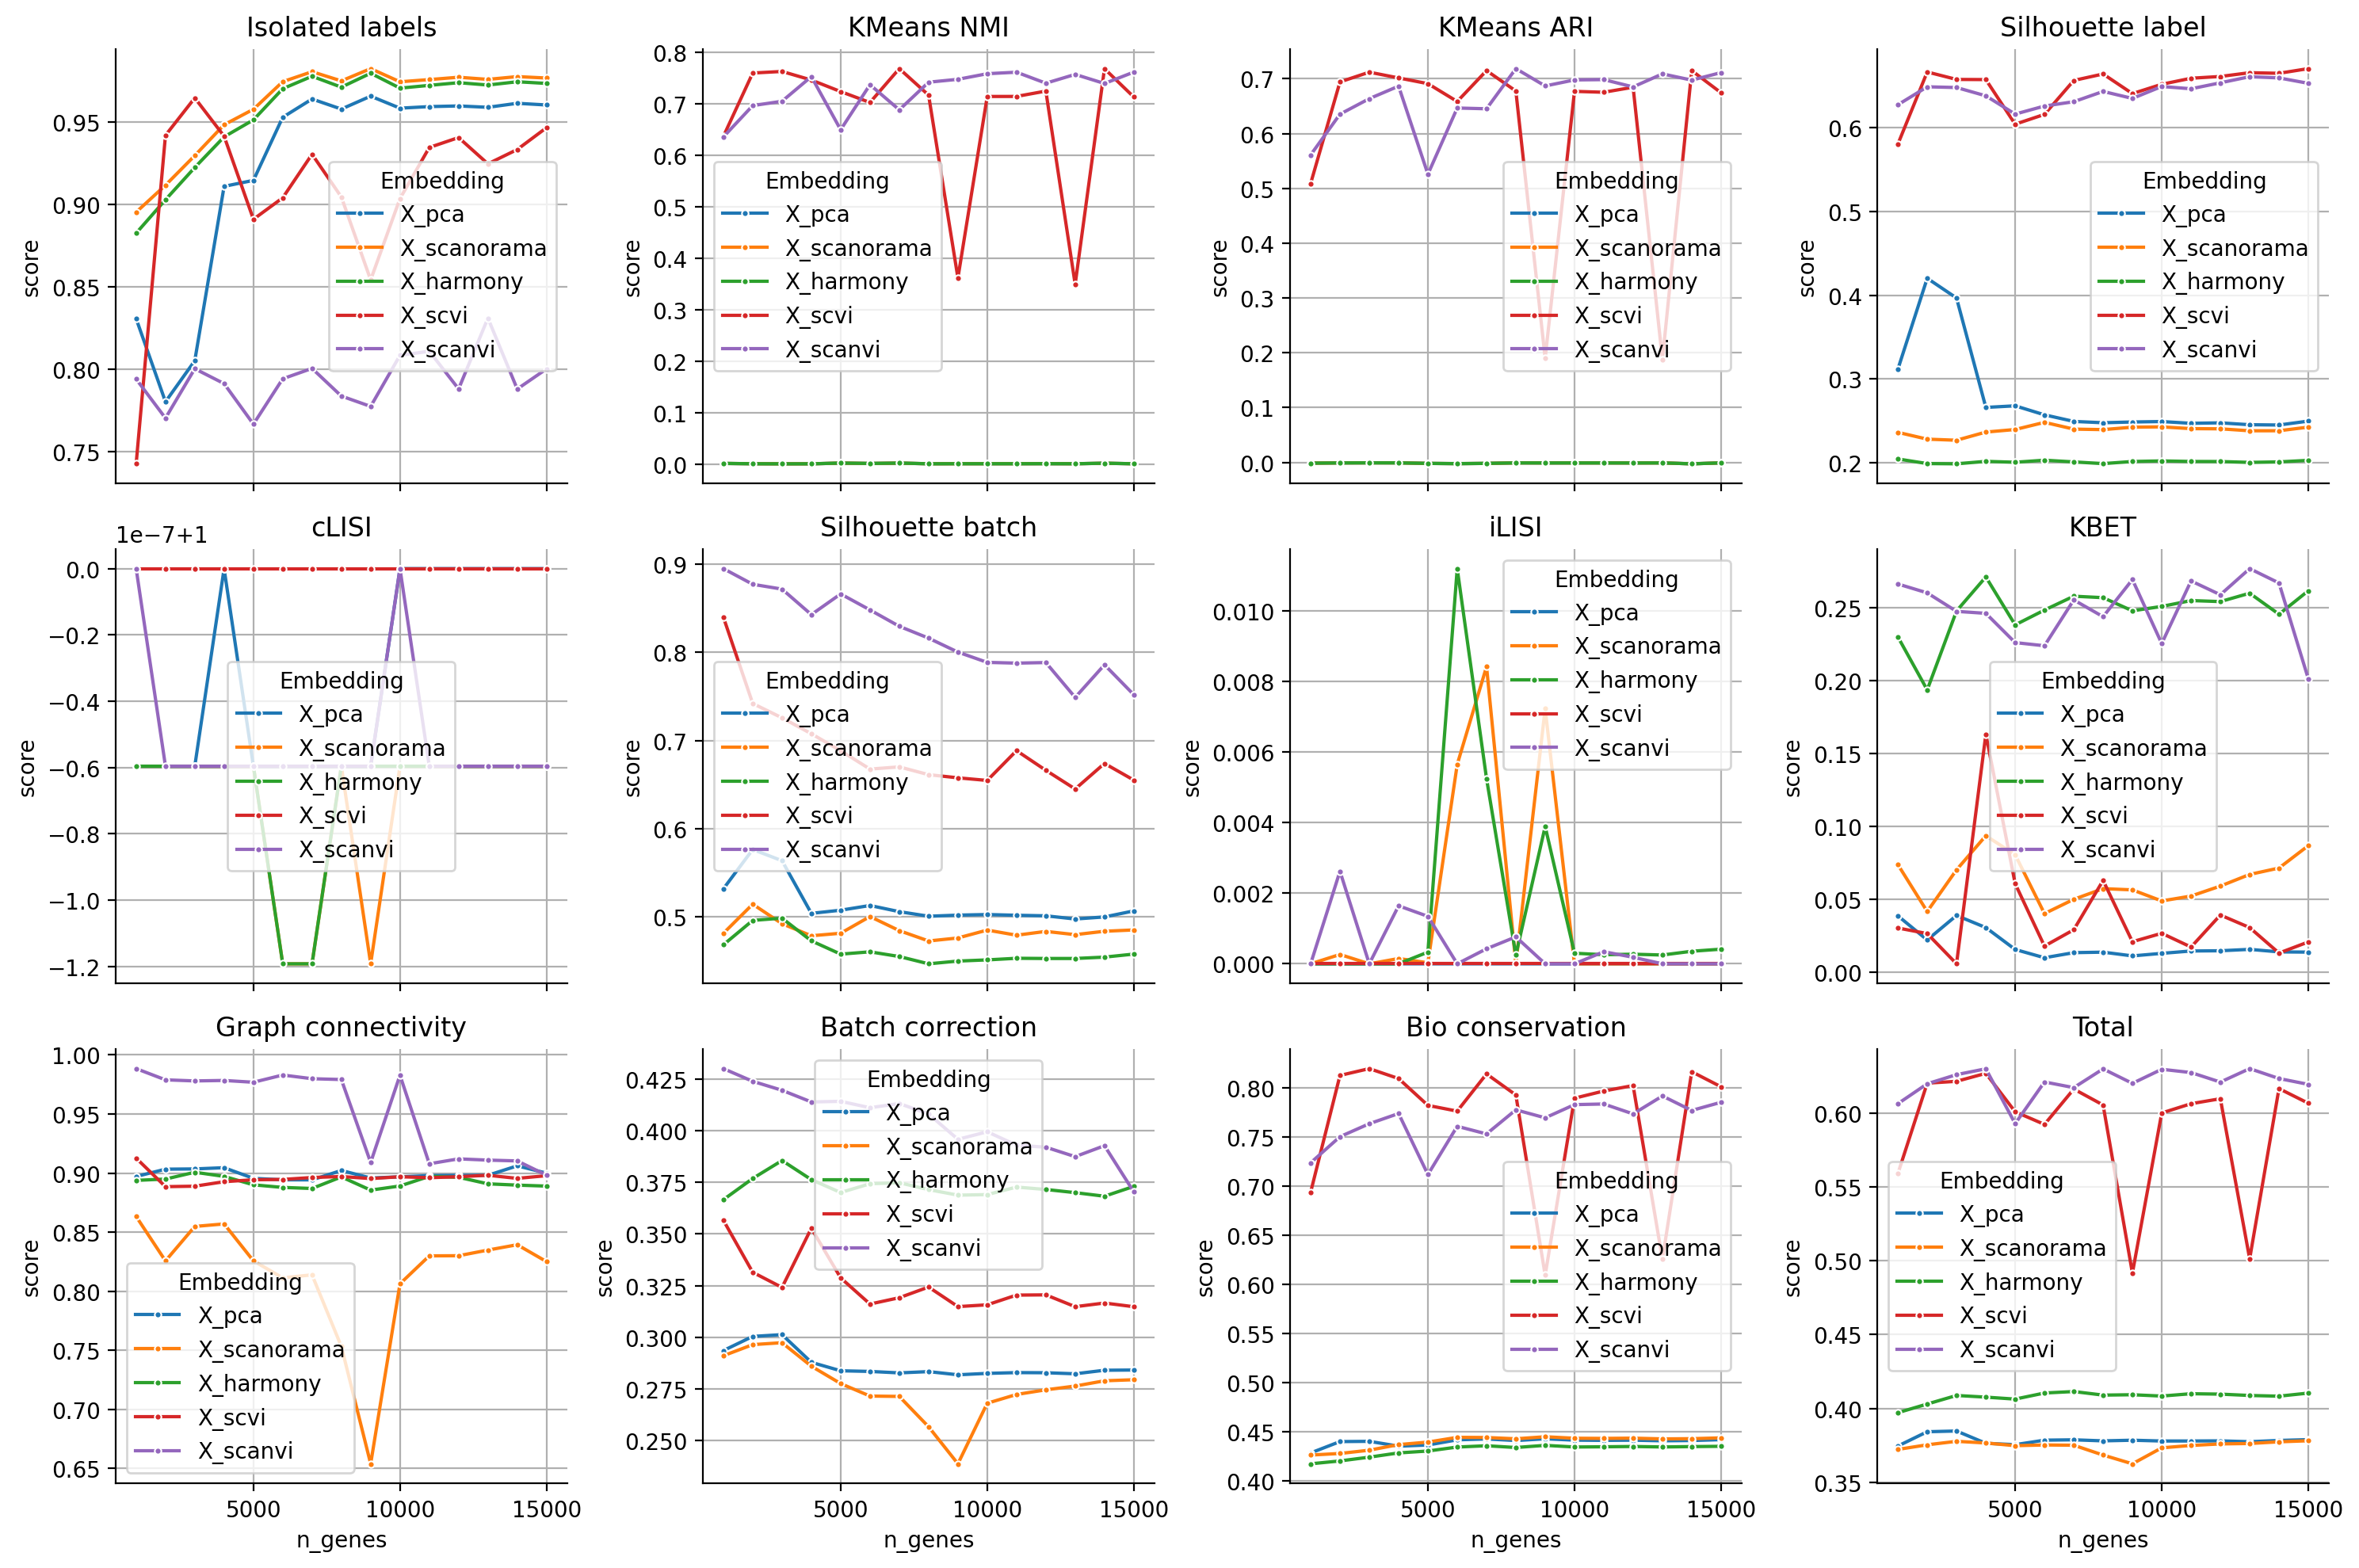

In [8]:
pdf = df.copy()

all_columns = list(pdf.columns)
remove_list = ['Embedding', 'n_genes', 'PCR comparison']
all_columns = [x for x in all_columns if not x in remove_list]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 15, 10
fig, axs = plt.subplots(3, 4, sharex=True)
axs = axs.ravel()


for i, column in enumerate(all_columns):

    sns.lineplot(
        data=pdf,
        x='n_genes',
        y=column,
        hue='Embedding',
        ax=axs[i],
        # legend=False,
        marker='.',
        lw=1.5,
    )

    axs[i].set_ylabel('score')
    axs[i].set_title(column)
    axs[i].grid(True)

    # break

sns.despine()
plt.tight_layout()
pdf.head()

# Rank by total score

In [9]:
pdf = df.copy()

pdf = pdf.sort_values(by='Total', ascending=False)
columns = [
    'n_genes',
    'Embedding',
    'Silhouette label',
    'Silhouette batch',
    'Batch correction',
    'Bio conservation',
    'Total',
]
pdf[columns].head()

,n_genes,Embedding,Silhouette label,Silhouette batch,Batch correction,Bio conservation,Total
4,13000.0,X_scanvi,0.660595,0.749021,0.387411,0.791629,0.629942
4,4000.0,X_scanvi,0.637797,0.842895,0.413865,0.773789,0.629819
4,8000.0,X_scanvi,0.643031,0.816217,0.408048,0.777545,0.629746
4,10000.0,X_scanvi,0.648943,0.788740,0.399449,0.782846,0.629487
4,11000.0,X_scanvi,0.646204,0.787895,0.392945,0.783496,0.627276


In [10]:
pdf = df.copy()

pdf = pdf.sort_values(by='Batch correction', ascending=False)
columns = [
    'n_genes',
    'Embedding',
    'Silhouette label',
    'Silhouette batch',
    'Batch correction',
    'Bio conservation',
    'Total',
]
pdf[columns].head()

,n_genes,Embedding,Silhouette label,Silhouette batch,Batch correction,Bio conservation,Total
4,1000.0,X_scanvi,0.627152,0.895037,0.429996,0.723677,0.606205
4,2000.0,X_scanvi,0.648563,0.877270,0.423850,0.750251,0.619690
4,3000.0,X_scanvi,0.647709,0.871792,0.419508,0.763430,0.625861
4,5000.0,X_scanvi,0.615991,0.866338,0.414176,0.711728,0.592707
4,4000.0,X_scanvi,0.637797,0.842895,0.413865,0.773789,0.629819


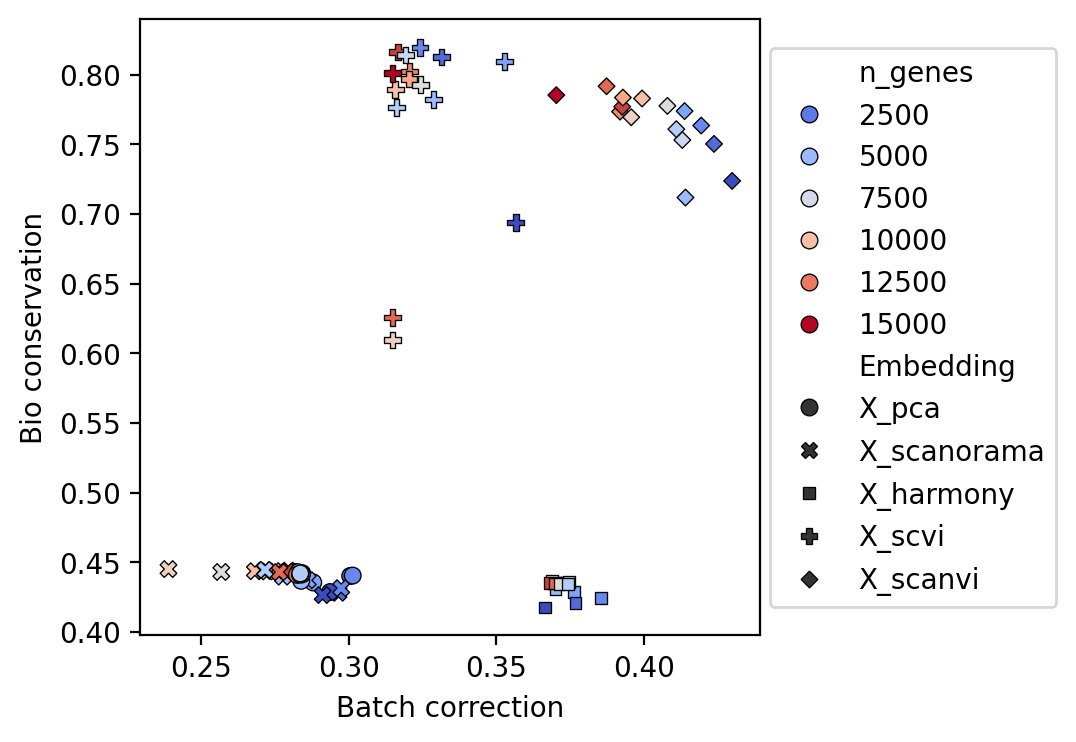

In [11]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=df,
    x='Batch correction',
    y='Bio conservation',
    hue='n_genes',
    ec='k',
    style='Embedding',
    palette='coolwarm',
)

sns.move_legend(
    plt.gca(),
    loc='center right',
    bbox_to_anchor=(1.5, 0.5),
)

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)